# EC500 - Group 6 - UNet-based Standard Deviation Noise Maps of CT Images 
**Avantika Kothandaraman, Caiwei Zhang, Long Chen**

This file is used to construct RatUNet archinecture and testing performance on RatUNet model.
Section 1-4 is the same as Data processing procedule implemented in UNet structure, Section 5 starts RatUNet model.

## Section-1: Installing the necessary packages

In [1]:
!pip install pynrrd
!pip install SimpleITK
!python -c "import monai" || pip install -q "monai"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install monai --upgrade

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torch.optim as optim
import os
import nibabel as nib
import nrrd
from torchvision.datasets import ImageFolder
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy import ndimage
import tempfile
import shutil
import glob

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    Activations,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureChannelFirst,
    Compose,
    AsChannelLastd,
    CropForegroundd,
    ScaleIntensityd,
    LoadImaged,
    Orientationd,
    Spacingd,
    Invertd,
    RandSpatialCropSamplesd,
    RandSpatialCropSamples,
    RandSpatialCropd,
    ScaleIntensityRanged,
    ScaleIntensityRange,
    RandRotated,
    RandFlipd,
    RandZoomd,
    RandScaleIntensityd, 
    RandShiftIntensityd,
    #AddChannel,
    ToTensord,
    NormalizeIntensityd
)
from monai.handlers.utils import from_engine 
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference 
from monai.inferers import SlidingWindowInferer
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
from patchify import patchify
import monai.transforms as mTransforms
import math
import torch.nn.functional as F


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [3]:
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [4]:
import gc

gc.collect()

torch.cuda.empty_cache()

## Section-2: Initial data inspection and experimentation

In [5]:
# initializing directory
data_dir = "/projectnb/ec500kb/projects/Project6/scans"
#data_dir2 = "/projectnb/ec500kb/projects/Project6/aug_scans"

In [6]:
# looping through for inspection
count = 0
dims = []
sizes = []
shapes = []

for filename in os.listdir(data_dir):
    if filename.endswith('.nrrd'):
        count += 1
        img, header = nrrd.read(os.path.join(data_dir,filename))
        dims.append(img.ndim)
        sizes.append(img.size)
        shapes.append(img.shape)
        
dims_check = all(dim == dims[0] for dim in dims)
size_check = all(size == sizes[0] for size in sizes)
shape_check = all(shape == shapes[0] for shape in shapes)

if dims_check and size_check and shape_check:
    print('Dimensions, shapes and sizes are uniform')
else:
    print('Dimensions, shapes and sizes are NOT uniform')
    
print('The total number of images in the dataset is {}'.format(count))

Dimensions, shapes and sizes are NOT uniform
The total number of images in the dataset is 30


In [7]:
list(shapes)

[(512, 512, 318),
 (512, 512, 318),
 (512, 512, 823),
 (512, 512, 526),
 (512, 512, 610),
 (512, 512, 823),
 (512, 512, 600),
 (512, 512, 525),
 (512, 512, 560),
 (512, 512, 856),
 (512, 512, 560),
 (512, 512, 610),
 (512, 512, 600),
 (512, 512, 610),
 (512, 512, 585),
 (512, 512, 318),
 (512, 512, 525),
 (512, 512, 526),
 (512, 512, 526),
 (512, 512, 823),
 (512, 512, 525),
 (512, 512, 600),
 (512, 512, 856),
 (512, 512, 533),
 (512, 512, 585),
 (512, 512, 533),
 (512, 512, 560),
 (512, 512, 533),
 (512, 512, 585),
 (512, 512, 856)]

In [8]:
def convert_to_2d(img_volume, axis=1):
    return np.max(img_volume, axis=axis)

trans = transforms.Compose([
    transforms.ToTensor()
    #transforms.Resize((512,512)),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

In [9]:
volume, header = nrrd.read(os.path.join(data_dir,'L506_signal.nrrd'))
volume_2d = convert_to_2d(volume)
volume_2d = trans(volume_2d)
print(volume.shape, volume_2d.squeeze().shape, volume_2d.dtype)

(512, 512, 526) torch.Size([512, 526]) torch.int16


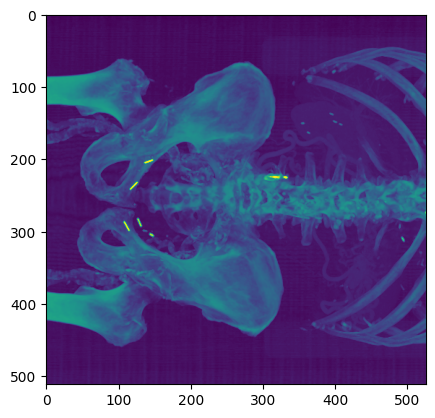

In [10]:
plt.imshow(volume_2d.squeeze())
plt.show()

In [12]:
def patches(image):
    demo_dict = []
    image = image.squeeze()
    patches = patchify(image.numpy(), (64,64), step=64)
        
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            single_patch_img = patches[i,j,:,:]
            demo_dict.append(single_patch_img)
    return demo_dict

In [13]:
patch1 = patches(volume_2d)

In [14]:
len(patch1)

64

In [15]:
patch1[2].shape

(64, 64)

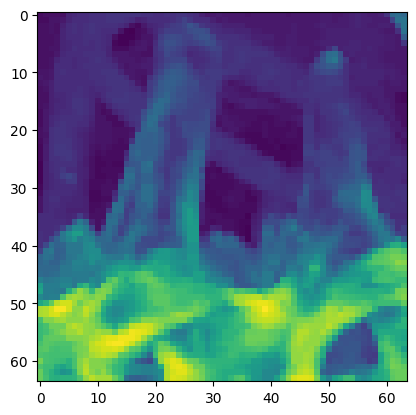

In [16]:
plt.imshow(patch1[30])

## Set deterministic seed for reproducibility

In [17]:
# 4, 54, 104
set_determinism(seed=4)

## Section-3: Creating a custom dataset and making transforms for augmentation


In [18]:
class CustomData(torch.utils.data.Dataset):

    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        #self.transforms = transforms
        image_sizes = []
        
        for file in os.listdir(self.root_dir):
            if file.endswith('signal.nrrd'):
                image_id = file.split('_')[0]
                
                # reading in the images
                signal_nrrd, _ = nrrd.read(os.path.join(self.root_dir, file))
                noise_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_noise.nrrd"))
                std_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_std.nrrd"))
                
                # Convert to 2D Axial and to tensors
                signal = torch.tensor(np.max(signal_nrrd, axis=1), dtype=torch.float32)
                noise = torch.tensor(np.max(noise_nrrd, axis=1), dtype=torch.float32)
                std = torch.tensor(np.max(std_nrrd, axis=1), dtype=torch.float32)

                # Normalize the images
                #signal = (signal - signal.min()) / (signal.max() - signal.min())
                #noise = (noise - noise.min()) / (noise.max() - noise.min())
                #std = (std - std.min()) / (std.max() - std.min())

                # generating input image fromm signal and noise
                k = random.uniform(0,5)
                ct_generated = signal + (k*noise)
                
                # generating patches
                ct_patches = patches(ct_generated)
                std_patches = patches(std)
                print(ct_generated.shape, len(ct_patches), len(std_patches))
                
                # storing the new dataset in a dictionary
                for i in range(len(ct_patches)):
                    self.data.append({'ct_generated' : ct_patches[i], 'std_map' : std_patches[i]})
                
                
    def data_info(self, idx):
        item = self.data[idx]
        ct_gen = item['ct_generated']
        std_ma = item['std_map']

        # Print the index of the data item
        print(f"Data item {idx}:")

        # Print the shape of the ct_generated tensor
        print(f"ct_generated shape: {ct_gen.shape}")

        # Print the shape of the std_map tensor
        print(f"std_map shape: {std_ma.shape}")
        
        print(f"ct_generated dtype: {ct_gen.dtype}")
        print(f"std_map dtype: {ct_gen.dtype}")

        print()
            
            
    def plot_ct(self, idx):
        item = self.data[idx]
        ct_generated = item['ct_generated']
        std_map = item['std_map']
        
        # Create a figure
        plt.figure(figsize=(5,5))
        
        # Plot axial view of ct_generated
        plt.subplot(1, 2, 1)
        plt.imshow(ct_generated, cmap='gray')
        plt.title('ct_generated Patch-0')
        plt.axis('off')
        
        # Plot axial view of std_map
        plt.subplot(1, 2, 2)
        plt.imshow(std_map, cmap='hot')
        plt.title('std_map Patch-0')
        plt.axis('off')
        
        # Show the plots
        plt.show()

            
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        #item = self.transforms(item)
        return item

In [19]:
custom_dataset = CustomData(root_dir = data_dir)

torch.Size([512, 823]) 96 96
torch.Size([512, 526]) 64 64
torch.Size([512, 600]) 72 72
torch.Size([512, 525]) 64 64
torch.Size([512, 610]) 72 72
torch.Size([512, 318]) 32 32
torch.Size([512, 856]) 104 104
torch.Size([512, 533]) 64 64
torch.Size([512, 585]) 72 72
torch.Size([512, 560]) 64 64


In [20]:
len(custom_dataset)

704

In [21]:
custom_dataset.data_info(10)

Data item 10:
ct_generated shape: (64, 64)
std_map shape: (64, 64)
ct_generated dtype: float32
std_map dtype: float32



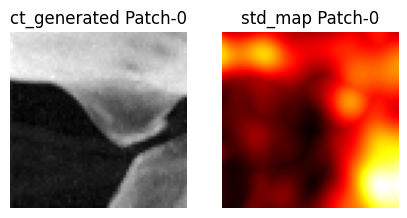

In [22]:
custom_dataset.plot_ct(12)

In [23]:
# transforms for data augmentation and refining

train_transforms = transforms.Compose([#ScaleIntensityd(keys = ['ct_generated', 'std_map']), 
                                       RandRotated(keys = ['ct_generated', 'std_map'], range_x=(-np.pi/12, np.pi/12), prob = 0.5, keep_size = True) 
                                       #RandFlipd(keys = ['ct_generated', 'std_map'], spatial_axis = 0, prob = 0.5), 
                                       #RandZoomd(keys = ['ct_generated', 'std_map'], zoom = (0.9,1.1), prob = 0.5) 
])

val_transforms = transforms.Compose([#ScaleIntensityd(keys = ['ct_generated', 'std_map']),
                                     RandRotated(keys = ['ct_generated', 'std_map'], range_x=(-np.pi/12, np.pi/12), prob = 0.5, keep_size = True)
                                     #RandFlipd(keys = ['ct_generated', 'std_map'], spatial_axis = 0, prob = 0.5, keep_size = True)
                                     #RandZoomd(keys = ['ct_generated', 'std_map'], zoom = (0.9,1.1), prob = 0.5, keep_size = True) 
])

## Section-4: Data Loader

In [24]:
train_dataset, val_dataset, test_dataset = custom_dataset[:568], custom_dataset[568:640], custom_dataset[640:]
#train_dataset, val_dataset, test_dataset = custom_dataset[:512], custom_dataset[512:576], custom_dataset[576:]
batch_size=1

#train_dataset, testval = train_test_split(custom_dataset, test_size=0.2, random_state=42, shuffle=False)
#val_dataset, test_dataset = train_test_split(testval, test_size=0.5, random_state=42, shuffle=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print(len(train_loader), len(val_loader), len(test_loader))

568 72 64


In [25]:
# Function to print the size of DataLoader
def print_dataloader_sizes(loader, name):
    # Total number of samples
    total_samples = len(loader.dataset)
    
    # Number of batches
    num_batches = len(loader)
    
    # Assuming all batches have the same size except possibly the last one
    batch_size = loader.batch_size
    
    print(f'{name} DataLoader has:')
    print(f'  Total samples: {total_samples}')
    print(f'  Number of batches: {num_batches}')
    print(f'  Batch size: {batch_size}')
    if total_samples % batch_size != 0:
        print(f'  Last batch size: {total_samples % batch_size}')
    else:
        print(f'  All batches have the same size')

# Checking sizes for each DataLoader
print_dataloader_sizes(train_loader, 'Train')
print_dataloader_sizes(val_loader, 'Validation')
print_dataloader_sizes(test_loader, 'Test')


Train DataLoader has:
  Total samples: 568
  Number of batches: 568
  Batch size: 1
  All batches have the same size
Validation DataLoader has:
  Total samples: 72
  Number of batches: 72
  Batch size: 1
  All batches have the same size
Test DataLoader has:
  Total samples: 64
  Number of batches: 64
  Batch size: 1
  All batches have the same size


## Section-5: RATUNet Training and Testing

In [26]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_rate=0.0):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),  # Dropout layer added here
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)  # Dropout layer added here
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class RatUNet(nn.Module):
    def __init__(self, block, num_features=64, dropout_rate=0.0): 
        super(RatUNet, self).__init__()
        self.inplanes = num_features

        self.conv = DoubleConv(1, num_features, dropout_rate=dropout_rate) 
        #self.conv = nn.Conv2d(1, num_features, kernel_size=3, stride=1, padding=1, bias=True)

        self.layer1 = self._make_layer(block, 64, 128, 3, stride=2)
        self.layer2 = self._make_layer(block, 128, 256, 3, stride=2)

        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.layer3 = self._make_layer(block, 256, 512, 4, stride=2)
        self.deconv2 = nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)

        self.layer4 = self._make_layer(block, 256, 256, 3)
        self.layer5 = self._make_layer(block, 128, 128, 3)
        self.layer6 = self._make_layer(block, 128, 128, 2)
        self.conv2 = nn.Sequential(nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=True),
                                   nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=True),
                                   nn.ReLU(inplace=True),
                                   )
        self.ca = SequentialPolarizedSelfAttention(128)
        self.lastconv = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1, bias=True)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0.0, math.sqrt(1.0 / n))
                if m.bias is not None:  # Check if the bias is not None before zeroing it
                    m.bias.data.zero_()

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        layers = []
        downsample = None
        self.inplanes = inplanes
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes),
                nn.AvgPool2d(kernel_size=2, stride=stride)
            )
            
#        if  stride == 1 and self.inplanes == 2*planes:
#            downsample = nn.Sequential(
#                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=True),
#                #nn.BatchNorm2d(planes)
#            )
        
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        res = self.conv(x)

        res2 = self.layer1(res)
        res3 = self.layer2(res2)        
        out = self.layer3(res3)
        
        out = self.deconv1(out)               
        out = self.layer4(out)
        out = torch.cat((out, res3), dim=1) 

        out = self.deconv2(out)        
        out = self.layer5(out)
        out = torch.cat((out, res2), dim=1)
        
        out = self.deconv3(out)        
        out = self.layer6(out)
        out = torch.cat((out, res), dim=1)
        
        out = self.conv2(out)
        out = self.ca(out)
        #out = self.lastconv(out)
        noise_pred = self.lastconv(out)
        
        #return x - out
        return noise_pred


In [37]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(dropout_rate)  # Dropout layer added here
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        #self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        #out = self.dropout(out)  # Dropout applied here

        out = self.conv2(out)
        #out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


In [38]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=True),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=True))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class SequentialPolarizedSelfAttention(nn.Module):

    def __init__(self, channel=512):
        super().__init__()
        self.ch_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.ch_wq=nn.Conv2d(channel,1,kernel_size=(1,1))
        self.softmax_channel=nn.Softmax(1)
        self.softmax_spatial=nn.Softmax(-1)
        self.ch_wz=nn.Conv2d(channel//2,channel,kernel_size=(1,1))
        self.ln=nn.LayerNorm(channel)
        self.sigmoid=nn.Sigmoid()
        self.sp_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.sp_wq=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.agp=nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        b, c, h, w = x.size()

        #Channel-only Self-Attention
        channel_wv=self.ch_wv(x) #bs,c//2,h,w
        channel_wq=self.ch_wq(x) #bs,1,h,w
        channel_wv=channel_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        channel_wq=channel_wq.reshape(b,-1,1) #bs,h*w,1
        channel_wq=self.softmax_channel(channel_wq)
        channel_wz=torch.matmul(channel_wv,channel_wq).unsqueeze(-1) #bs,c//2,1,1
        channel_weight=self.sigmoid(self.ch_wz(channel_wz).reshape(b,c,1).permute(0,2,1)).permute(0,2,1).reshape(b,c,1,1) #bs,c,1,1self.ln(
        channel_out=channel_weight*x

        #Spatial-only Self-Attention
        spatial_wv=self.sp_wv(channel_out) #bs,c//2,h,w
        spatial_wq=self.sp_wq(channel_out) #bs,c//2,h,w
        spatial_wq=self.agp(spatial_wq) #bs,c//2,1,1
        spatial_wv=spatial_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        spatial_wq=spatial_wq.permute(0,2,3,1).reshape(b,1,c//2) #bs,1,c//2
        spatial_wq=self.softmax_spatial(spatial_wq)
        spatial_wz=torch.matmul(spatial_wq,spatial_wv) #bs,1,h*w
        spatial_weight=self.sigmoid(spatial_wz.reshape(b,1,h,w)) #bs,1,h,w
        spatial_out=spatial_weight*channel_out
        return spatial_out


In [43]:
# LOSS Function - Average Relative Error
def average_relative_error(output, target, epsilon=1e-8):
    absolute_error = torch.abs(output - target)
    # Adding epsilon to the denominator to avoid division by zero
    relative_error = absolute_error / (torch.abs(target) + epsilon)
    return torch.mean(relative_error)

In [44]:
# Model and optimizer initialization
device = "cuda" if torch.cuda.is_available() else "cpu"
#model = RatUNet(BasicBlock, 64).to(device)
model = RatUNet(BasicBlock, num_features=64, dropout_rate=0.0).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
#criterion = nn.MSELoss()
#criterion = nn.L1Loss()
model_saving_path = './results/RatUNet_test_nodr.pth'

# Train the model
total_step = len(train_loader)
num_epochs = 300
best_val_loss = float('inf')  # Initialize best validation loss for model saving

In [45]:
# training and validation

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        img = img.unsqueeze(0)
        std_map = images['std_map'].float().to(device)
        std_map = std_map.unsqueeze(0)
        #print(img.shape)
        #print(std_map.shape)
        optimizer.zero_grad()
        y_pred = model(img)
        #print(y_pred.shape)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            img = img.unsqueeze(0)
            std_map = image['std_map'].float().to(device)
            std_map = std_map.unsqueeze(0)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Save model if validation loss has improved
        if epoch_val_loss < best_val_loss:
            print(f"Validation loss decreased ({best_val_loss:.6f} --> {epoch_val_loss:.6f}).  Saving model ...")
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), model_saving_path)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


100%|██████████| 72/72 [00:00<00:00, 187.32it/s]


Validation loss decreased (inf --> 0.276709).  Saving model ...
Epoch [1/300], Train Loss: 0.4891, Validation Loss: 0.2767


100%|██████████| 72/72 [00:00<00:00, 187.83it/s]


Epoch [2/300], Train Loss: 0.2633, Validation Loss: 0.3689


100%|██████████| 72/72 [00:00<00:00, 187.62it/s]


Epoch [3/300], Train Loss: 0.2536, Validation Loss: 0.2824


100%|██████████| 72/72 [00:00<00:00, 187.85it/s]


Epoch [4/300], Train Loss: 0.2406, Validation Loss: 0.3565


100%|██████████| 72/72 [00:00<00:00, 187.69it/s]


Epoch [5/300], Train Loss: 0.2312, Validation Loss: 0.3308


100%|██████████| 72/72 [00:00<00:00, 187.44it/s]


Epoch [6/300], Train Loss: 0.2189, Validation Loss: 0.3538


100%|██████████| 72/72 [00:00<00:00, 187.63it/s]


Epoch [7/300], Train Loss: 0.2074, Validation Loss: 0.2847


100%|██████████| 72/72 [00:00<00:00, 188.08it/s]


Epoch [8/300], Train Loss: 0.1952, Validation Loss: 0.3399


100%|██████████| 72/72 [00:00<00:00, 187.96it/s]


Epoch [9/300], Train Loss: 0.1990, Validation Loss: 0.3076


100%|██████████| 72/72 [00:00<00:00, 187.47it/s]


Epoch [10/300], Train Loss: 0.1787, Validation Loss: 0.2992


100%|██████████| 72/72 [00:00<00:00, 188.05it/s]


Epoch [11/300], Train Loss: 0.1676, Validation Loss: 0.3306


100%|██████████| 72/72 [00:00<00:00, 188.55it/s]


Epoch [12/300], Train Loss: 0.1604, Validation Loss: 0.3248


100%|██████████| 72/72 [00:00<00:00, 187.95it/s]


Epoch [13/300], Train Loss: 0.1527, Validation Loss: 0.3047


100%|██████████| 72/72 [00:00<00:00, 187.96it/s]


Epoch [14/300], Train Loss: 0.1447, Validation Loss: 0.3024


100%|██████████| 72/72 [00:00<00:00, 187.59it/s]


Epoch [15/300], Train Loss: 0.1356, Validation Loss: 0.3086


100%|██████████| 72/72 [00:00<00:00, 187.75it/s]


Epoch [16/300], Train Loss: 0.1268, Validation Loss: 0.2768


100%|██████████| 72/72 [00:00<00:00, 187.97it/s]


Epoch [17/300], Train Loss: 0.1230, Validation Loss: 0.3218


100%|██████████| 72/72 [00:00<00:00, 187.87it/s]


Epoch [18/300], Train Loss: 0.1168, Validation Loss: 0.2939


100%|██████████| 72/72 [00:00<00:00, 187.98it/s]


Epoch [19/300], Train Loss: 0.1105, Validation Loss: 0.2988


100%|██████████| 72/72 [00:00<00:00, 188.24it/s]


Epoch [20/300], Train Loss: 0.1089, Validation Loss: 0.3098


100%|██████████| 72/72 [00:00<00:00, 188.27it/s]


Epoch [21/300], Train Loss: 0.1012, Validation Loss: 0.2864


100%|██████████| 72/72 [00:00<00:00, 187.98it/s]


Epoch [22/300], Train Loss: 0.0980, Validation Loss: 0.2904


100%|██████████| 72/72 [00:00<00:00, 188.03it/s]


Validation loss decreased (0.276709 --> 0.260400).  Saving model ...
Epoch [23/300], Train Loss: 0.0954, Validation Loss: 0.2604


100%|██████████| 72/72 [00:00<00:00, 187.60it/s]


Epoch [24/300], Train Loss: 0.0932, Validation Loss: 0.2621


100%|██████████| 72/72 [00:00<00:00, 187.28it/s]


Epoch [25/300], Train Loss: 0.0925, Validation Loss: 0.2857


100%|██████████| 72/72 [00:00<00:00, 187.26it/s]


Validation loss decreased (0.260400 --> 0.258080).  Saving model ...
Epoch [26/300], Train Loss: 0.0901, Validation Loss: 0.2581


100%|██████████| 72/72 [00:00<00:00, 187.49it/s]


Validation loss decreased (0.258080 --> 0.252644).  Saving model ...
Epoch [27/300], Train Loss: 0.0895, Validation Loss: 0.2526


100%|██████████| 72/72 [00:00<00:00, 187.44it/s]


Epoch [28/300], Train Loss: 0.0861, Validation Loss: 0.2852


100%|██████████| 72/72 [00:00<00:00, 187.85it/s]


Epoch [29/300], Train Loss: 0.0823, Validation Loss: 0.2585


100%|██████████| 72/72 [00:00<00:00, 187.28it/s]


Validation loss decreased (0.252644 --> 0.252023).  Saving model ...
Epoch [30/300], Train Loss: 0.0800, Validation Loss: 0.2520


100%|██████████| 72/72 [00:00<00:00, 187.90it/s]


Epoch [31/300], Train Loss: 0.0812, Validation Loss: 0.2941


100%|██████████| 72/72 [00:00<00:00, 187.33it/s]


Epoch [32/300], Train Loss: 0.0791, Validation Loss: 0.2755


100%|██████████| 72/72 [00:00<00:00, 187.56it/s]


Epoch [33/300], Train Loss: 0.0776, Validation Loss: 0.2797


100%|██████████| 72/72 [00:00<00:00, 187.48it/s]


Validation loss decreased (0.252023 --> 0.240974).  Saving model ...
Epoch [34/300], Train Loss: 0.0772, Validation Loss: 0.2410


100%|██████████| 72/72 [00:00<00:00, 187.22it/s]


Epoch [35/300], Train Loss: 0.0753, Validation Loss: 0.3226


100%|██████████| 72/72 [00:00<00:00, 187.33it/s]


Epoch [36/300], Train Loss: 0.0732, Validation Loss: 0.2567


100%|██████████| 72/72 [00:00<00:00, 186.52it/s]


Epoch [37/300], Train Loss: 0.0716, Validation Loss: 0.2575


100%|██████████| 72/72 [00:00<00:00, 187.40it/s]


Validation loss decreased (0.240974 --> 0.231944).  Saving model ...
Epoch [38/300], Train Loss: 0.0709, Validation Loss: 0.2319


100%|██████████| 72/72 [00:00<00:00, 187.41it/s]


Epoch [39/300], Train Loss: 0.0678, Validation Loss: 0.2731


100%|██████████| 72/72 [00:00<00:00, 187.49it/s]


Epoch [40/300], Train Loss: 0.0666, Validation Loss: 0.2668


100%|██████████| 72/72 [00:00<00:00, 187.39it/s]


Epoch [41/300], Train Loss: 0.0654, Validation Loss: 0.2456


100%|██████████| 72/72 [00:00<00:00, 187.56it/s]


Epoch [42/300], Train Loss: 0.0650, Validation Loss: 0.2611


100%|██████████| 72/72 [00:00<00:00, 187.83it/s]


Validation loss decreased (0.231944 --> 0.221071).  Saving model ...
Epoch [43/300], Train Loss: 0.0627, Validation Loss: 0.2211


100%|██████████| 72/72 [00:00<00:00, 187.43it/s]


Validation loss decreased (0.221071 --> 0.202463).  Saving model ...
Epoch [44/300], Train Loss: 0.0619, Validation Loss: 0.2025


100%|██████████| 72/72 [00:00<00:00, 187.80it/s]


Epoch [45/300], Train Loss: 0.0608, Validation Loss: 0.2143


100%|██████████| 72/72 [00:00<00:00, 187.51it/s]


Epoch [46/300], Train Loss: 0.0586, Validation Loss: 0.2330


100%|██████████| 72/72 [00:00<00:00, 187.54it/s]


Epoch [47/300], Train Loss: 0.0590, Validation Loss: 0.2048


100%|██████████| 72/72 [00:00<00:00, 187.47it/s]


Epoch [48/300], Train Loss: 0.0559, Validation Loss: 0.2081


100%|██████████| 72/72 [00:00<00:00, 188.07it/s]


Epoch [49/300], Train Loss: 0.0549, Validation Loss: 0.2332


100%|██████████| 72/72 [00:00<00:00, 187.72it/s]


Validation loss decreased (0.202463 --> 0.200934).  Saving model ...
Epoch [50/300], Train Loss: 0.0538, Validation Loss: 0.2009


100%|██████████| 72/72 [00:00<00:00, 187.42it/s]


Epoch [51/300], Train Loss: 0.0650, Validation Loss: 0.2211


100%|██████████| 72/72 [00:00<00:00, 187.14it/s]


Epoch [52/300], Train Loss: 0.0518, Validation Loss: 0.2496


100%|██████████| 72/72 [00:00<00:00, 187.01it/s]


Epoch [53/300], Train Loss: 0.0497, Validation Loss: 0.2264


100%|██████████| 72/72 [00:00<00:00, 187.42it/s]


Validation loss decreased (0.200934 --> 0.178960).  Saving model ...
Epoch [54/300], Train Loss: 0.0490, Validation Loss: 0.1790


100%|██████████| 72/72 [00:00<00:00, 187.39it/s]


Epoch [55/300], Train Loss: 0.0493, Validation Loss: 0.2128


100%|██████████| 72/72 [00:00<00:00, 187.40it/s]


Epoch [56/300], Train Loss: 0.0513, Validation Loss: 0.1874


100%|██████████| 72/72 [00:00<00:00, 187.57it/s]


Epoch [57/300], Train Loss: 0.0497, Validation Loss: 0.2528


100%|██████████| 72/72 [00:00<00:00, 187.23it/s]


Epoch [58/300], Train Loss: 0.0477, Validation Loss: 0.1876


100%|██████████| 72/72 [00:00<00:00, 187.20it/s]


Epoch [59/300], Train Loss: 0.0465, Validation Loss: 0.1942


100%|██████████| 72/72 [00:00<00:00, 187.45it/s]


Epoch [60/300], Train Loss: 0.0453, Validation Loss: 0.2540


100%|██████████| 72/72 [00:00<00:00, 187.57it/s]


Epoch [61/300], Train Loss: 0.0487, Validation Loss: 0.2629


100%|██████████| 72/72 [00:00<00:00, 187.44it/s]


Epoch [62/300], Train Loss: 0.0525, Validation Loss: 0.2465


100%|██████████| 72/72 [00:00<00:00, 187.67it/s]


Epoch [63/300], Train Loss: 0.0432, Validation Loss: 0.2569


100%|██████████| 72/72 [00:00<00:00, 187.47it/s]


Epoch [64/300], Train Loss: 0.0431, Validation Loss: 0.2208


100%|██████████| 72/72 [00:00<00:00, 187.66it/s]


Epoch [65/300], Train Loss: 0.0434, Validation Loss: 0.2501


100%|██████████| 72/72 [00:00<00:00, 187.46it/s]


Epoch [66/300], Train Loss: 0.0429, Validation Loss: 0.2339


100%|██████████| 72/72 [00:00<00:00, 187.86it/s]


Epoch [67/300], Train Loss: 0.0426, Validation Loss: 0.2420


100%|██████████| 72/72 [00:00<00:00, 187.52it/s]


Epoch [68/300], Train Loss: 0.0424, Validation Loss: 0.2413


100%|██████████| 72/72 [00:00<00:00, 187.25it/s]


Epoch [69/300], Train Loss: 0.0408, Validation Loss: 0.1821


100%|██████████| 72/72 [00:00<00:00, 187.52it/s]


Epoch [70/300], Train Loss: 0.0419, Validation Loss: 0.2272


100%|██████████| 72/72 [00:00<00:00, 187.40it/s]


Epoch [71/300], Train Loss: 0.0414, Validation Loss: 0.2531


100%|██████████| 72/72 [00:00<00:00, 187.57it/s]


Epoch [72/300], Train Loss: 0.0401, Validation Loss: 0.2494


100%|██████████| 72/72 [00:00<00:00, 187.57it/s]


Epoch [73/300], Train Loss: 0.0386, Validation Loss: 0.2747


100%|██████████| 72/72 [00:00<00:00, 188.01it/s]


Epoch [74/300], Train Loss: 0.0398, Validation Loss: 0.2586


100%|██████████| 72/72 [00:00<00:00, 187.43it/s]


Epoch [75/300], Train Loss: 0.0407, Validation Loss: 0.2001


100%|██████████| 72/72 [00:00<00:00, 187.65it/s]


Epoch [76/300], Train Loss: 0.0416, Validation Loss: 0.2409


100%|██████████| 72/72 [00:00<00:00, 187.62it/s]


Epoch [77/300], Train Loss: 0.0398, Validation Loss: 0.1989


100%|██████████| 72/72 [00:00<00:00, 187.27it/s]


Epoch [78/300], Train Loss: 0.0364, Validation Loss: 0.1854


100%|██████████| 72/72 [00:00<00:00, 187.49it/s]


Epoch [79/300], Train Loss: 0.0387, Validation Loss: 0.2082


100%|██████████| 72/72 [00:00<00:00, 187.49it/s]


Epoch [80/300], Train Loss: 0.0368, Validation Loss: 0.2022


100%|██████████| 72/72 [00:00<00:00, 187.37it/s]


Epoch [81/300], Train Loss: 0.0358, Validation Loss: 0.1943


100%|██████████| 72/72 [00:00<00:00, 187.77it/s]


Epoch [82/300], Train Loss: 0.0368, Validation Loss: 0.2660


100%|██████████| 72/72 [00:00<00:00, 187.70it/s]


Epoch [83/300], Train Loss: 0.0371, Validation Loss: 0.2362


100%|██████████| 72/72 [00:00<00:00, 187.44it/s]


Epoch [84/300], Train Loss: 0.0361, Validation Loss: 0.2466


100%|██████████| 72/72 [00:00<00:00, 187.65it/s]


Validation loss decreased (0.178960 --> 0.178104).  Saving model ...
Epoch [85/300], Train Loss: 0.0345, Validation Loss: 0.1781


100%|██████████| 72/72 [00:00<00:00, 187.52it/s]


Epoch [86/300], Train Loss: 0.0353, Validation Loss: 0.2486


100%|██████████| 72/72 [00:00<00:00, 187.70it/s]


Epoch [87/300], Train Loss: 0.0348, Validation Loss: 0.2103


100%|██████████| 72/72 [00:00<00:00, 187.26it/s]


Epoch [88/300], Train Loss: 0.0348, Validation Loss: 0.2301


100%|██████████| 72/72 [00:00<00:00, 187.11it/s]


Epoch [89/300], Train Loss: 0.0358, Validation Loss: 0.2211


100%|██████████| 72/72 [00:00<00:00, 187.29it/s]


Epoch [90/300], Train Loss: 0.0338, Validation Loss: 0.2401


100%|██████████| 72/72 [00:00<00:00, 187.66it/s]


Epoch [91/300], Train Loss: 0.0344, Validation Loss: 0.1961


100%|██████████| 72/72 [00:00<00:00, 187.33it/s]


Epoch [92/300], Train Loss: 0.0330, Validation Loss: 0.2278


100%|██████████| 72/72 [00:00<00:00, 187.19it/s]


Validation loss decreased (0.178104 --> 0.169321).  Saving model ...
Epoch [93/300], Train Loss: 0.0325, Validation Loss: 0.1693


100%|██████████| 72/72 [00:00<00:00, 187.48it/s]


Epoch [94/300], Train Loss: 0.0340, Validation Loss: 0.2011


100%|██████████| 72/72 [00:00<00:00, 187.39it/s]


Epoch [95/300], Train Loss: 0.0334, Validation Loss: 0.1917


100%|██████████| 72/72 [00:00<00:00, 187.12it/s]


Epoch [96/300], Train Loss: 0.0327, Validation Loss: 0.2121


100%|██████████| 72/72 [00:00<00:00, 187.32it/s]


Epoch [97/300], Train Loss: 0.0334, Validation Loss: 0.2531


100%|██████████| 72/72 [00:00<00:00, 187.55it/s]


Epoch [98/300], Train Loss: 0.0331, Validation Loss: 0.2480


100%|██████████| 72/72 [00:00<00:00, 187.46it/s]


Epoch [99/300], Train Loss: 0.0316, Validation Loss: 0.2639


100%|██████████| 72/72 [00:00<00:00, 187.72it/s]


Epoch [100/300], Train Loss: 0.0297, Validation Loss: 0.2225


100%|██████████| 72/72 [00:00<00:00, 188.02it/s]


Epoch [101/300], Train Loss: 0.0304, Validation Loss: 0.1813


100%|██████████| 72/72 [00:00<00:00, 187.66it/s]


Epoch [102/300], Train Loss: 0.0314, Validation Loss: 0.2091


100%|██████████| 72/72 [00:00<00:00, 187.35it/s]


Epoch [103/300], Train Loss: 0.0323, Validation Loss: 0.2481


100%|██████████| 72/72 [00:00<00:00, 187.16it/s]


Epoch [104/300], Train Loss: 0.0300, Validation Loss: 0.2210


100%|██████████| 72/72 [00:00<00:00, 187.55it/s]


Epoch [105/300], Train Loss: 0.0299, Validation Loss: 0.2578


100%|██████████| 72/72 [00:00<00:00, 187.35it/s]


Epoch [106/300], Train Loss: 0.0296, Validation Loss: 0.2118


100%|██████████| 72/72 [00:00<00:00, 187.87it/s]


Epoch [107/300], Train Loss: 0.0296, Validation Loss: 0.1943


100%|██████████| 72/72 [00:00<00:00, 187.55it/s]


Epoch [108/300], Train Loss: 0.0304, Validation Loss: 0.2097


100%|██████████| 72/72 [00:00<00:00, 187.53it/s]


Epoch [109/300], Train Loss: 0.0286, Validation Loss: 0.2227


100%|██████████| 72/72 [00:00<00:00, 187.51it/s]


Validation loss decreased (0.169321 --> 0.166053).  Saving model ...
Epoch [110/300], Train Loss: 0.0327, Validation Loss: 0.1661


100%|██████████| 72/72 [00:00<00:00, 187.64it/s]


Epoch [111/300], Train Loss: 0.0294, Validation Loss: 0.2730


100%|██████████| 72/72 [00:00<00:00, 187.33it/s]


Epoch [112/300], Train Loss: 0.0289, Validation Loss: 0.2114


100%|██████████| 72/72 [00:00<00:00, 187.57it/s]


Epoch [113/300], Train Loss: 0.0283, Validation Loss: 0.2018


100%|██████████| 72/72 [00:00<00:00, 187.30it/s]


Epoch [114/300], Train Loss: 0.0289, Validation Loss: 0.1869


100%|██████████| 72/72 [00:00<00:00, 187.45it/s]


Epoch [115/300], Train Loss: 0.0291, Validation Loss: 0.2166


100%|██████████| 72/72 [00:00<00:00, 187.55it/s]


Epoch [116/300], Train Loss: 0.0285, Validation Loss: 0.1984


100%|██████████| 72/72 [00:00<00:00, 188.00it/s]


Epoch [117/300], Train Loss: 0.0266, Validation Loss: 0.2157


100%|██████████| 72/72 [00:00<00:00, 187.40it/s]


Epoch [118/300], Train Loss: 0.0288, Validation Loss: 0.2493


100%|██████████| 72/72 [00:00<00:00, 188.09it/s]


Epoch [119/300], Train Loss: 0.0281, Validation Loss: 0.2464


100%|██████████| 72/72 [00:00<00:00, 188.15it/s]


Epoch [120/300], Train Loss: 0.0279, Validation Loss: 0.2476


100%|██████████| 72/72 [00:00<00:00, 187.73it/s]


Epoch [121/300], Train Loss: 0.0277, Validation Loss: 0.2334


100%|██████████| 72/72 [00:00<00:00, 187.65it/s]


Epoch [122/300], Train Loss: 0.0287, Validation Loss: 0.2315


100%|██████████| 72/72 [00:00<00:00, 187.99it/s]


Epoch [123/300], Train Loss: 0.0274, Validation Loss: 0.2410


100%|██████████| 72/72 [00:00<00:00, 187.73it/s]


Epoch [124/300], Train Loss: 0.0258, Validation Loss: 0.2145


100%|██████████| 72/72 [00:00<00:00, 186.75it/s]


Epoch [125/300], Train Loss: 0.0284, Validation Loss: 0.2356


100%|██████████| 72/72 [00:00<00:00, 187.93it/s]


Epoch [126/300], Train Loss: 0.0276, Validation Loss: 0.2614


100%|██████████| 72/72 [00:00<00:00, 187.62it/s]


Epoch [127/300], Train Loss: 0.0270, Validation Loss: 0.2190


100%|██████████| 72/72 [00:00<00:00, 187.42it/s]


Epoch [128/300], Train Loss: 0.0266, Validation Loss: 0.1975


100%|██████████| 72/72 [00:00<00:00, 187.62it/s]


Epoch [129/300], Train Loss: 0.0267, Validation Loss: 0.1916


100%|██████████| 72/72 [00:00<00:00, 187.36it/s]


Epoch [130/300], Train Loss: 0.0252, Validation Loss: 0.1792


100%|██████████| 72/72 [00:00<00:00, 187.60it/s]


Epoch [131/300], Train Loss: 0.0263, Validation Loss: 0.1952


100%|██████████| 72/72 [00:00<00:00, 187.59it/s]


Epoch [132/300], Train Loss: 0.0262, Validation Loss: 0.1945


100%|██████████| 72/72 [00:00<00:00, 187.67it/s]


Epoch [133/300], Train Loss: 0.0254, Validation Loss: 0.2192


100%|██████████| 72/72 [00:00<00:00, 187.97it/s]


Epoch [134/300], Train Loss: 0.0255, Validation Loss: 0.2053


100%|██████████| 72/72 [00:00<00:00, 187.48it/s]


Epoch [135/300], Train Loss: 0.0254, Validation Loss: 0.1852


100%|██████████| 72/72 [00:00<00:00, 187.40it/s]


Epoch [136/300], Train Loss: 0.0263, Validation Loss: 0.2124


100%|██████████| 72/72 [00:00<00:00, 187.87it/s]


Epoch [137/300], Train Loss: 0.0269, Validation Loss: 0.2313


100%|██████████| 72/72 [00:00<00:00, 187.62it/s]


Epoch [138/300], Train Loss: 0.0257, Validation Loss: 0.1978


100%|██████████| 72/72 [00:00<00:00, 187.49it/s]


Epoch [139/300], Train Loss: 0.0254, Validation Loss: 0.2389


100%|██████████| 72/72 [00:00<00:00, 187.62it/s]


Epoch [140/300], Train Loss: 0.0249, Validation Loss: 0.2489


100%|██████████| 72/72 [00:00<00:00, 187.39it/s]


Epoch [141/300], Train Loss: 0.0253, Validation Loss: 0.2178


100%|██████████| 72/72 [00:00<00:00, 187.49it/s]


Epoch [142/300], Train Loss: 0.0256, Validation Loss: 0.2133


100%|██████████| 72/72 [00:00<00:00, 187.51it/s]


Epoch [143/300], Train Loss: 0.0249, Validation Loss: 0.2460


100%|██████████| 72/72 [00:00<00:00, 187.60it/s]


Epoch [144/300], Train Loss: 0.0250, Validation Loss: 0.1936


100%|██████████| 72/72 [00:00<00:00, 187.76it/s]


Epoch [145/300], Train Loss: 0.0249, Validation Loss: 0.2199


100%|██████████| 72/72 [00:00<00:00, 187.51it/s]


Epoch [146/300], Train Loss: 0.0246, Validation Loss: 0.2116


100%|██████████| 72/72 [00:00<00:00, 187.57it/s]


Epoch [147/300], Train Loss: 0.0253, Validation Loss: 0.1896


100%|██████████| 72/72 [00:00<00:00, 187.68it/s]


Epoch [148/300], Train Loss: 0.0239, Validation Loss: 0.1937


100%|██████████| 72/72 [00:00<00:00, 187.07it/s]


Epoch [149/300], Train Loss: 0.0241, Validation Loss: 0.1971


100%|██████████| 72/72 [00:00<00:00, 187.52it/s]


Epoch [150/300], Train Loss: 0.0234, Validation Loss: 0.1915


100%|██████████| 72/72 [00:00<00:00, 187.54it/s]


Epoch [151/300], Train Loss: 0.0230, Validation Loss: 0.2134


100%|██████████| 72/72 [00:00<00:00, 187.43it/s]


Epoch [152/300], Train Loss: 0.0239, Validation Loss: 0.2093


100%|██████████| 72/72 [00:00<00:00, 187.66it/s]


Epoch [153/300], Train Loss: 0.0256, Validation Loss: 0.2267


100%|██████████| 72/72 [00:00<00:00, 187.61it/s]


Epoch [154/300], Train Loss: 0.0232, Validation Loss: 0.2584


100%|██████████| 72/72 [00:00<00:00, 187.55it/s]


Epoch [155/300], Train Loss: 0.0227, Validation Loss: 0.2092


100%|██████████| 72/72 [00:00<00:00, 187.49it/s]


Epoch [156/300], Train Loss: 0.0228, Validation Loss: 0.2089


100%|██████████| 72/72 [00:00<00:00, 188.07it/s]


Epoch [157/300], Train Loss: 0.0234, Validation Loss: 0.1743


100%|██████████| 72/72 [00:00<00:00, 187.72it/s]


Epoch [158/300], Train Loss: 0.0226, Validation Loss: 0.1870


100%|██████████| 72/72 [00:00<00:00, 187.89it/s]


Epoch [159/300], Train Loss: 0.0237, Validation Loss: 0.1917


100%|██████████| 72/72 [00:00<00:00, 187.84it/s]


Epoch [160/300], Train Loss: 0.0228, Validation Loss: 0.1866


100%|██████████| 72/72 [00:00<00:00, 187.48it/s]


Epoch [161/300], Train Loss: 0.0223, Validation Loss: 0.2283


100%|██████████| 72/72 [00:00<00:00, 187.28it/s]


Epoch [162/300], Train Loss: 0.0230, Validation Loss: 0.2003


100%|██████████| 72/72 [00:00<00:00, 187.89it/s]


Epoch [163/300], Train Loss: 0.0221, Validation Loss: 0.2422


100%|██████████| 72/72 [00:00<00:00, 187.84it/s]


Epoch [164/300], Train Loss: 0.0216, Validation Loss: 0.1821


100%|██████████| 72/72 [00:00<00:00, 187.62it/s]


Epoch [165/300], Train Loss: 0.0217, Validation Loss: 0.2142


100%|██████████| 72/72 [00:00<00:00, 188.02it/s]


Epoch [166/300], Train Loss: 0.0220, Validation Loss: 0.2134


100%|██████████| 72/72 [00:00<00:00, 188.00it/s]


Epoch [167/300], Train Loss: 0.0233, Validation Loss: 0.2493


100%|██████████| 72/72 [00:00<00:00, 187.36it/s]


Epoch [168/300], Train Loss: 0.0220, Validation Loss: 0.2225


100%|██████████| 72/72 [00:00<00:00, 187.20it/s]


Epoch [169/300], Train Loss: 0.0219, Validation Loss: 0.2030


100%|██████████| 72/72 [00:00<00:00, 187.39it/s]


Epoch [170/300], Train Loss: 0.0220, Validation Loss: 0.2313


100%|██████████| 72/72 [00:00<00:00, 187.63it/s]


Epoch [171/300], Train Loss: 0.0213, Validation Loss: 0.2559


100%|██████████| 72/72 [00:00<00:00, 187.55it/s]


Epoch [172/300], Train Loss: 0.0235, Validation Loss: 0.2196


100%|██████████| 72/72 [00:00<00:00, 187.52it/s]


Epoch [173/300], Train Loss: 0.0228, Validation Loss: 0.2086


100%|██████████| 72/72 [00:00<00:00, 187.40it/s]


Epoch [174/300], Train Loss: 0.0211, Validation Loss: 0.2190


100%|██████████| 72/72 [00:00<00:00, 187.73it/s]


Epoch [175/300], Train Loss: 0.0211, Validation Loss: 0.2265


100%|██████████| 72/72 [00:00<00:00, 187.41it/s]


Epoch [176/300], Train Loss: 0.0209, Validation Loss: 0.2398


100%|██████████| 72/72 [00:00<00:00, 187.30it/s]


Epoch [177/300], Train Loss: 0.0213, Validation Loss: 0.2428


100%|██████████| 72/72 [00:00<00:00, 187.83it/s]


Epoch [178/300], Train Loss: 0.0218, Validation Loss: 0.2589


100%|██████████| 72/72 [00:00<00:00, 187.74it/s]


Epoch [179/300], Train Loss: 0.0214, Validation Loss: 0.2199


100%|██████████| 72/72 [00:00<00:00, 187.32it/s]


Epoch [180/300], Train Loss: 0.0205, Validation Loss: 0.1902


100%|██████████| 72/72 [00:00<00:00, 188.40it/s]


Epoch [181/300], Train Loss: 0.0212, Validation Loss: 0.1845


100%|██████████| 72/72 [00:00<00:00, 187.39it/s]


Epoch [182/300], Train Loss: 0.0218, Validation Loss: 0.2664


100%|██████████| 72/72 [00:00<00:00, 187.98it/s]


Epoch [183/300], Train Loss: 0.0228, Validation Loss: 0.2241


100%|██████████| 72/72 [00:00<00:00, 188.06it/s]


Epoch [184/300], Train Loss: 0.0209, Validation Loss: 0.2520


100%|██████████| 72/72 [00:00<00:00, 187.68it/s]


Epoch [185/300], Train Loss: 0.0196, Validation Loss: 0.2199


100%|██████████| 72/72 [00:00<00:00, 188.07it/s]


Epoch [186/300], Train Loss: 0.0194, Validation Loss: 0.2193


100%|██████████| 72/72 [00:00<00:00, 187.78it/s]


Epoch [187/300], Train Loss: 0.0197, Validation Loss: 0.2441


100%|██████████| 72/72 [00:00<00:00, 187.84it/s]


Epoch [188/300], Train Loss: 0.0213, Validation Loss: 0.2023


100%|██████████| 72/72 [00:00<00:00, 187.83it/s]


Epoch [189/300], Train Loss: 0.0204, Validation Loss: 0.1934


100%|██████████| 72/72 [00:00<00:00, 187.67it/s]


Epoch [190/300], Train Loss: 0.0210, Validation Loss: 0.2150


100%|██████████| 72/72 [00:00<00:00, 187.53it/s]


Epoch [191/300], Train Loss: 0.0205, Validation Loss: 0.1896


100%|██████████| 72/72 [00:00<00:00, 187.90it/s]


Epoch [192/300], Train Loss: 0.0183, Validation Loss: 0.1819


100%|██████████| 72/72 [00:00<00:00, 187.71it/s]


Epoch [193/300], Train Loss: 0.0202, Validation Loss: 0.1852


100%|██████████| 72/72 [00:00<00:00, 187.75it/s]


Epoch [194/300], Train Loss: 0.0214, Validation Loss: 0.2314


100%|██████████| 72/72 [00:00<00:00, 187.84it/s]


Epoch [195/300], Train Loss: 0.0215, Validation Loss: 0.2270


100%|██████████| 72/72 [00:00<00:00, 187.67it/s]


Epoch [196/300], Train Loss: 0.0197, Validation Loss: 0.2367


100%|██████████| 72/72 [00:00<00:00, 187.84it/s]


Epoch [197/300], Train Loss: 0.0199, Validation Loss: 0.1932


100%|██████████| 72/72 [00:00<00:00, 187.33it/s]


Epoch [198/300], Train Loss: 0.0193, Validation Loss: 0.2039


100%|██████████| 72/72 [00:00<00:00, 187.58it/s]


Epoch [199/300], Train Loss: 0.0193, Validation Loss: 0.1937


100%|██████████| 72/72 [00:00<00:00, 187.50it/s]


Epoch [200/300], Train Loss: 0.0188, Validation Loss: 0.1825


100%|██████████| 72/72 [00:00<00:00, 187.76it/s]


Epoch [201/300], Train Loss: 0.0193, Validation Loss: 0.1936


100%|██████████| 72/72 [00:00<00:00, 187.56it/s]


Epoch [202/300], Train Loss: 0.0205, Validation Loss: 0.2054


100%|██████████| 72/72 [00:00<00:00, 187.78it/s]


Epoch [203/300], Train Loss: 0.0199, Validation Loss: 0.2275


100%|██████████| 72/72 [00:00<00:00, 187.89it/s]


Epoch [204/300], Train Loss: 0.0184, Validation Loss: 0.1919


100%|██████████| 72/72 [00:00<00:00, 187.65it/s]


Epoch [205/300], Train Loss: 0.0186, Validation Loss: 0.2287


100%|██████████| 72/72 [00:00<00:00, 187.54it/s]


Epoch [206/300], Train Loss: 0.0190, Validation Loss: 0.2244


100%|██████████| 72/72 [00:00<00:00, 187.68it/s]


Epoch [207/300], Train Loss: 0.0185, Validation Loss: 0.2381


100%|██████████| 72/72 [00:00<00:00, 187.60it/s]


Epoch [208/300], Train Loss: 0.0189, Validation Loss: 0.2052


100%|██████████| 72/72 [00:00<00:00, 187.59it/s]


Epoch [209/300], Train Loss: 0.0186, Validation Loss: 0.2611


100%|██████████| 72/72 [00:00<00:00, 186.95it/s]


Epoch [210/300], Train Loss: 0.0192, Validation Loss: 0.2137


100%|██████████| 72/72 [00:00<00:00, 187.98it/s]


Epoch [211/300], Train Loss: 0.0194, Validation Loss: 0.2061


100%|██████████| 72/72 [00:00<00:00, 187.94it/s]


Epoch [212/300], Train Loss: 0.0188, Validation Loss: 0.1879


100%|██████████| 72/72 [00:00<00:00, 187.41it/s]


Epoch [213/300], Train Loss: 0.0189, Validation Loss: 0.1988


100%|██████████| 72/72 [00:00<00:00, 187.62it/s]


Epoch [214/300], Train Loss: 0.0184, Validation Loss: 0.2054


100%|██████████| 72/72 [00:00<00:00, 187.96it/s]


Epoch [215/300], Train Loss: 0.0191, Validation Loss: 0.1803


100%|██████████| 72/72 [00:00<00:00, 187.77it/s]


Epoch [216/300], Train Loss: 0.0189, Validation Loss: 0.1736


100%|██████████| 72/72 [00:00<00:00, 187.76it/s]


Epoch [217/300], Train Loss: 0.0187, Validation Loss: 0.2442


100%|██████████| 72/72 [00:00<00:00, 187.62it/s]


Epoch [218/300], Train Loss: 0.0189, Validation Loss: 0.2208


100%|██████████| 72/72 [00:00<00:00, 187.70it/s]


Epoch [219/300], Train Loss: 0.0183, Validation Loss: 0.2128


100%|██████████| 72/72 [00:00<00:00, 187.61it/s]


Epoch [220/300], Train Loss: 0.0184, Validation Loss: 0.2134


100%|██████████| 72/72 [00:00<00:00, 187.68it/s]


Epoch [221/300], Train Loss: 0.0182, Validation Loss: 0.1873


100%|██████████| 72/72 [00:00<00:00, 187.68it/s]


Epoch [222/300], Train Loss: 0.0175, Validation Loss: 0.2284


100%|██████████| 72/72 [00:00<00:00, 187.86it/s]


Epoch [223/300], Train Loss: 0.0172, Validation Loss: 0.2470


100%|██████████| 72/72 [00:00<00:00, 187.68it/s]


Epoch [224/300], Train Loss: 0.0168, Validation Loss: 0.2293


100%|██████████| 72/72 [00:00<00:00, 187.94it/s]


Epoch [225/300], Train Loss: 0.0176, Validation Loss: 0.1891


100%|██████████| 72/72 [00:00<00:00, 187.98it/s]


Epoch [226/300], Train Loss: 0.0171, Validation Loss: 0.2390


100%|██████████| 72/72 [00:00<00:00, 187.79it/s]


Epoch [227/300], Train Loss: 0.0176, Validation Loss: 0.2256


100%|██████████| 72/72 [00:00<00:00, 187.71it/s]


Epoch [228/300], Train Loss: 0.0185, Validation Loss: 0.2471


100%|██████████| 72/72 [00:00<00:00, 187.92it/s]


Epoch [229/300], Train Loss: 0.0174, Validation Loss: 0.1789


100%|██████████| 72/72 [00:00<00:00, 187.70it/s]


Epoch [230/300], Train Loss: 0.0185, Validation Loss: 0.2096


100%|██████████| 72/72 [00:00<00:00, 188.10it/s]


Epoch [231/300], Train Loss: 0.0180, Validation Loss: 0.2231


100%|██████████| 72/72 [00:00<00:00, 187.68it/s]


Epoch [232/300], Train Loss: 0.0175, Validation Loss: 0.2023


100%|██████████| 72/72 [00:00<00:00, 187.66it/s]


Epoch [233/300], Train Loss: 0.0176, Validation Loss: 0.2195


100%|██████████| 72/72 [00:00<00:00, 187.98it/s]


Epoch [234/300], Train Loss: 0.0174, Validation Loss: 0.1994


100%|██████████| 72/72 [00:00<00:00, 187.39it/s]


Epoch [235/300], Train Loss: 0.0174, Validation Loss: 0.1975


100%|██████████| 72/72 [00:00<00:00, 187.73it/s]


Epoch [236/300], Train Loss: 0.0180, Validation Loss: 0.2622


100%|██████████| 72/72 [00:00<00:00, 187.70it/s]


Epoch [237/300], Train Loss: 0.0181, Validation Loss: 0.1978


100%|██████████| 72/72 [00:00<00:00, 187.78it/s]


Epoch [238/300], Train Loss: 0.0169, Validation Loss: 0.2344


100%|██████████| 72/72 [00:00<00:00, 187.78it/s]


Epoch [239/300], Train Loss: 0.0171, Validation Loss: 0.2020


100%|██████████| 72/72 [00:00<00:00, 187.43it/s]


Epoch [240/300], Train Loss: 0.0177, Validation Loss: 0.1882


100%|██████████| 72/72 [00:00<00:00, 187.61it/s]


Epoch [241/300], Train Loss: 0.0177, Validation Loss: 0.2320


100%|██████████| 72/72 [00:00<00:00, 187.84it/s]


Epoch [242/300], Train Loss: 0.0176, Validation Loss: 0.1805


100%|██████████| 72/72 [00:00<00:00, 187.78it/s]


Epoch [243/300], Train Loss: 0.0184, Validation Loss: 0.2346


100%|██████████| 72/72 [00:00<00:00, 187.37it/s]


Epoch [244/300], Train Loss: 0.0168, Validation Loss: 0.2467


100%|██████████| 72/72 [00:00<00:00, 187.98it/s]


Epoch [245/300], Train Loss: 0.0161, Validation Loss: 0.2590


100%|██████████| 72/72 [00:00<00:00, 187.67it/s]


Epoch [246/300], Train Loss: 0.0161, Validation Loss: 0.2378


100%|██████████| 72/72 [00:00<00:00, 187.91it/s]


Epoch [247/300], Train Loss: 0.0173, Validation Loss: 0.2215


100%|██████████| 72/72 [00:00<00:00, 187.95it/s]


Epoch [248/300], Train Loss: 0.0172, Validation Loss: 0.2261


100%|██████████| 72/72 [00:00<00:00, 187.44it/s]


Epoch [249/300], Train Loss: 0.0185, Validation Loss: 0.2481


100%|██████████| 72/72 [00:00<00:00, 187.70it/s]


Epoch [250/300], Train Loss: 0.0170, Validation Loss: 0.2165


100%|██████████| 72/72 [00:00<00:00, 187.80it/s]


Epoch [251/300], Train Loss: 0.0166, Validation Loss: 0.2096


100%|██████████| 72/72 [00:00<00:00, 187.84it/s]


Epoch [252/300], Train Loss: 0.0164, Validation Loss: 0.1858


100%|██████████| 72/72 [00:00<00:00, 187.59it/s]


Epoch [253/300], Train Loss: 0.0160, Validation Loss: 0.2488


100%|██████████| 72/72 [00:00<00:00, 187.95it/s]


Epoch [254/300], Train Loss: 0.0164, Validation Loss: 0.2309


100%|██████████| 72/72 [00:00<00:00, 187.48it/s]


Epoch [255/300], Train Loss: 0.0174, Validation Loss: 0.2323


100%|██████████| 72/72 [00:00<00:00, 188.29it/s]


Epoch [256/300], Train Loss: 0.0167, Validation Loss: 0.2158


100%|██████████| 72/72 [00:00<00:00, 188.38it/s]


Epoch [257/300], Train Loss: 0.0166, Validation Loss: 0.2059


100%|██████████| 72/72 [00:00<00:00, 188.12it/s]


Epoch [258/300], Train Loss: 0.0165, Validation Loss: 0.1983


100%|██████████| 72/72 [00:00<00:00, 187.67it/s]


Epoch [259/300], Train Loss: 0.0170, Validation Loss: 0.2263


100%|██████████| 72/72 [00:00<00:00, 188.26it/s]


Epoch [260/300], Train Loss: 0.0160, Validation Loss: 0.2390


100%|██████████| 72/72 [00:00<00:00, 187.61it/s]


Epoch [261/300], Train Loss: 0.0163, Validation Loss: 0.2641


100%|██████████| 72/72 [00:00<00:00, 187.62it/s]


Epoch [262/300], Train Loss: 0.0163, Validation Loss: 0.1829


100%|██████████| 72/72 [00:00<00:00, 187.72it/s]


Epoch [263/300], Train Loss: 0.0157, Validation Loss: 0.2271


100%|██████████| 72/72 [00:00<00:00, 187.92it/s]


Epoch [264/300], Train Loss: 0.0159, Validation Loss: 0.2233


100%|██████████| 72/72 [00:00<00:00, 187.60it/s]


Epoch [265/300], Train Loss: 0.0162, Validation Loss: 0.2422


100%|██████████| 72/72 [00:00<00:00, 187.48it/s]


Epoch [266/300], Train Loss: 0.0159, Validation Loss: 0.1868


100%|██████████| 72/72 [00:00<00:00, 187.74it/s]


Epoch [267/300], Train Loss: 0.0167, Validation Loss: 0.2182


100%|██████████| 72/72 [00:00<00:00, 187.71it/s]


Epoch [268/300], Train Loss: 0.0163, Validation Loss: 0.2302


100%|██████████| 72/72 [00:00<00:00, 187.94it/s]


Epoch [269/300], Train Loss: 0.0158, Validation Loss: 0.2017


100%|██████████| 72/72 [00:00<00:00, 187.61it/s]


Epoch [270/300], Train Loss: 0.0155, Validation Loss: 0.2267


100%|██████████| 72/72 [00:00<00:00, 188.07it/s]


Epoch [271/300], Train Loss: 0.0164, Validation Loss: 0.2000


100%|██████████| 72/72 [00:00<00:00, 187.78it/s]


Epoch [272/300], Train Loss: 0.0155, Validation Loss: 0.2121


100%|██████████| 72/72 [00:00<00:00, 187.96it/s]


Epoch [273/300], Train Loss: 0.0164, Validation Loss: 0.1938


100%|██████████| 72/72 [00:00<00:00, 187.46it/s]


Epoch [274/300], Train Loss: 0.0157, Validation Loss: 0.2159


100%|██████████| 72/72 [00:00<00:00, 187.97it/s]


Epoch [275/300], Train Loss: 0.0157, Validation Loss: 0.2446


100%|██████████| 72/72 [00:00<00:00, 187.62it/s]


Epoch [276/300], Train Loss: 0.0159, Validation Loss: 0.2059


100%|██████████| 72/72 [00:00<00:00, 187.70it/s]


Epoch [277/300], Train Loss: 0.0151, Validation Loss: 0.2481


100%|██████████| 72/72 [00:00<00:00, 188.35it/s]


Epoch [278/300], Train Loss: 0.0163, Validation Loss: 0.2014


100%|██████████| 72/72 [00:00<00:00, 187.75it/s]


Epoch [279/300], Train Loss: 0.0167, Validation Loss: 0.2128


100%|██████████| 72/72 [00:00<00:00, 187.85it/s]


Epoch [280/300], Train Loss: 0.0162, Validation Loss: 0.2176


100%|██████████| 72/72 [00:00<00:00, 188.09it/s]


Epoch [281/300], Train Loss: 0.0157, Validation Loss: 0.2201


100%|██████████| 72/72 [00:00<00:00, 187.60it/s]


Epoch [282/300], Train Loss: 0.0147, Validation Loss: 0.1910


100%|██████████| 72/72 [00:00<00:00, 187.20it/s]


Epoch [283/300], Train Loss: 0.0147, Validation Loss: 0.2416


100%|██████████| 72/72 [00:00<00:00, 187.78it/s]


Epoch [284/300], Train Loss: 0.0152, Validation Loss: 0.1976


100%|██████████| 72/72 [00:00<00:00, 187.42it/s]


Epoch [285/300], Train Loss: 0.0150, Validation Loss: 0.2140


100%|██████████| 72/72 [00:00<00:00, 187.66it/s]


Epoch [286/300], Train Loss: 0.0155, Validation Loss: 0.2079


100%|██████████| 72/72 [00:00<00:00, 187.75it/s]


Epoch [287/300], Train Loss: 0.0149, Validation Loss: 0.1910


100%|██████████| 72/72 [00:00<00:00, 187.13it/s]


Epoch [288/300], Train Loss: 0.0149, Validation Loss: 0.1950


100%|██████████| 72/72 [00:00<00:00, 187.67it/s]


Epoch [289/300], Train Loss: 0.0150, Validation Loss: 0.2427


100%|██████████| 72/72 [00:00<00:00, 187.59it/s]


Epoch [290/300], Train Loss: 0.0155, Validation Loss: 0.1844


100%|██████████| 72/72 [00:00<00:00, 187.48it/s]


Epoch [291/300], Train Loss: 0.0142, Validation Loss: 0.2093


100%|██████████| 72/72 [00:00<00:00, 187.22it/s]


Epoch [292/300], Train Loss: 0.0136, Validation Loss: 0.2368


100%|██████████| 72/72 [00:00<00:00, 187.41it/s]


Epoch [293/300], Train Loss: 0.0148, Validation Loss: 0.2274


100%|██████████| 72/72 [00:00<00:00, 187.68it/s]


Epoch [294/300], Train Loss: 0.0150, Validation Loss: 0.1846


100%|██████████| 72/72 [00:00<00:00, 187.18it/s]


Epoch [295/300], Train Loss: 0.0145, Validation Loss: 0.2025


100%|██████████| 72/72 [00:00<00:00, 187.26it/s]


Epoch [296/300], Train Loss: 0.0156, Validation Loss: 0.2036


100%|██████████| 72/72 [00:00<00:00, 187.32it/s]


Epoch [297/300], Train Loss: 0.0153, Validation Loss: 0.2511


100%|██████████| 72/72 [00:00<00:00, 187.82it/s]


Epoch [298/300], Train Loss: 0.0143, Validation Loss: 0.2439


100%|██████████| 72/72 [00:00<00:00, 187.26it/s]


Epoch [299/300], Train Loss: 0.0148, Validation Loss: 0.2113


100%|██████████| 72/72 [00:00<00:00, 187.96it/s]

Epoch [300/300], Train Loss: 0.0148, Validation Loss: 0.2090


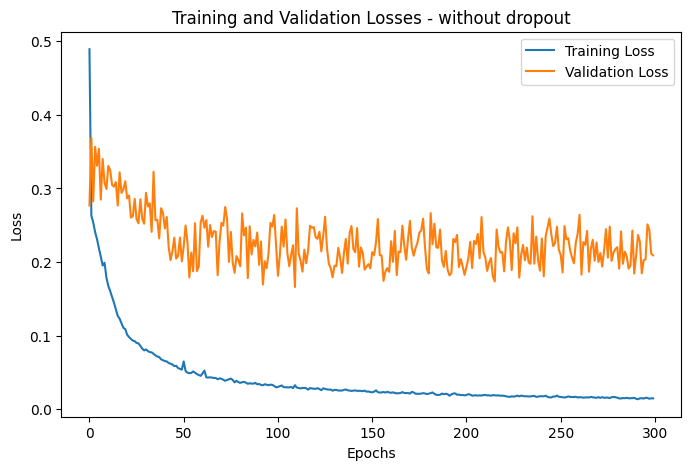

In [47]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses - without dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xticks(range(0, len(train_losses), 1))  # Specify tick locations every 5 epochs
plt.legend()
plt.show()

In [48]:
model.eval()

test_loss = 0.0
test_image = []
ground_truth = []
predicted_patches = []

model.to(device)

with torch.no_grad():
    for batch in test_loader:
        # moving data to device
        images = batch['ct_generated'].float().to(device)
        std_maps = batch['std_map'].float().to(device)
        
        images = images.unsqueeze(0)
        std_maps = std_maps.unsqueeze(0)

        y_pred = model(images)

        # calculating loss
        loss = average_relative_error(y_pred, std_maps)
        #loss = criterion(y_pred, std_maps)
        test_loss += loss.item() * images.size(0)
        y_pred = y_pred.squeeze(0)

        # appending data for visualization
        test_image.append(images.cpu().numpy())
        ground_truth.append(std_maps.cpu().numpy())
        predicted_patches.append(y_pred.cpu().numpy())

# calculating average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.2098


In [49]:
# visualizing prediction

test_image_array = np.array(test_image)
ground_truth_array = np.array(ground_truth)
predicted_patches_array = np.array(predicted_patches)

test_image_array = test_image_array.reshape(8,8,64,64)
ground_truth_array = ground_truth_array.reshape(8,8,64,64)
predicted_patches_array = predicted_patches_array.reshape(8,8,64,64)

test_image_final = np.concatenate([np.concatenate(row, axis=1) for row in test_image_array], axis=0)
ground_truth_final = np.concatenate([np.concatenate(row, axis=1) for row in ground_truth_array], axis=0)
predicted_patches_final = np.concatenate([np.concatenate(row, axis=1) for row in predicted_patches_array], axis=0)
# Save the predicted_patches_final array to a file
#np.save('./results/seed104_nodr_predict.npy', predicted_patches_final)

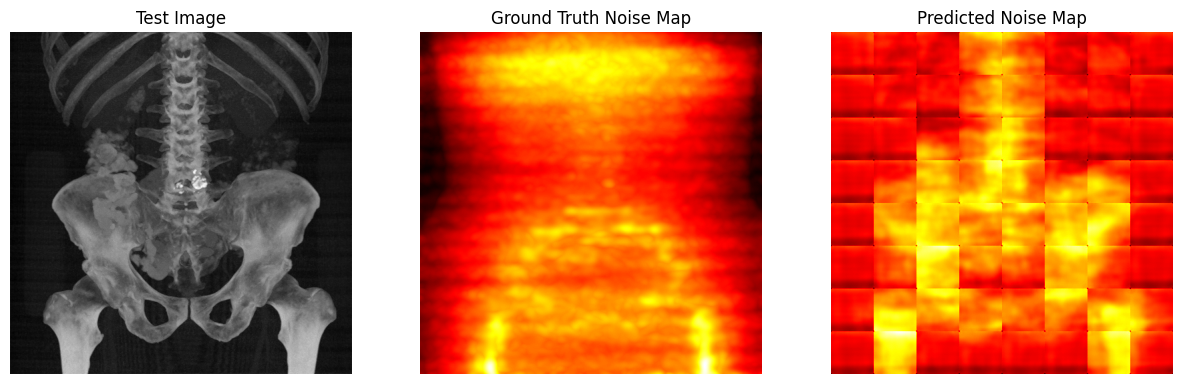

In [50]:
# Plot the test image
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(np.rot90(test_image_final), cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.rot90(ground_truth_final), cmap='hot')
plt.title('Ground Truth Noise Map')
plt.axis('off')


plt.subplot(133)
plt.imshow(np.rot90(predicted_patches_final), cmap='hot')
plt.title('Predicted Noise Map')
plt.axis('off')
plt.show()

In [35]:
# Load the predicted_patches_final array from a file
p4 = np.load('./results/seed4_predict.npy')
p54 = np.load('./results/seed54_predict.npy')
p104 = np.load('./results/seed104_predict.npy')
average_prediction = (p4 + p54 + p104) / 3
print(average_prediction)

[[3999.8645 4871.531  5033.97   ... 4936.045  4666.3335 3600.28  ]
 [4744.9673 4945.1304 4991.7095 ... 4878.156  4908.0605 4729.7017]
 [5013.9746 4983.16   5032.0586 ... 4882.194  4944.135  4993.936 ]
 ...
 [5431.666  5408.0225 5390.4336 ... 4940.971  4937.5947 4940.028 ]
 [5038.848  5337.5903 5403.4272 ... 4920.143  4899.9355 4693.8467]
 [3831.991  4937.8687 5405.101  ... 4908.145  4628.5874 3786.7356]]


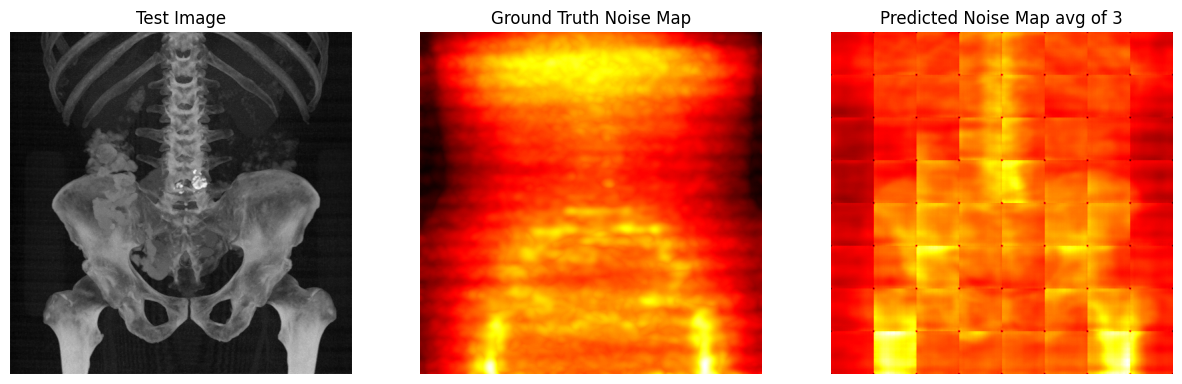

In [36]:
# Plot the test image
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(np.rot90(test_image_final), cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.rot90(ground_truth_final), cmap='hot')
plt.title('Ground Truth Noise Map')
plt.axis('off')

plt.subplot(133)
plt.imshow(np.rot90(average_prediction), cmap='hot')
plt.title('Predicted Noise Map avg of 3')
plt.axis('off')
plt.show()

In [37]:
percent_error = (np.array(ground_truth_final) - np.array(average_prediction)) / np.array(ground_truth_final)
average_percent_error = abs(np.mean(np.abs(percent_error)))
print(average_percent_error)

0.13748218


Average Percentage Error: 13.75%


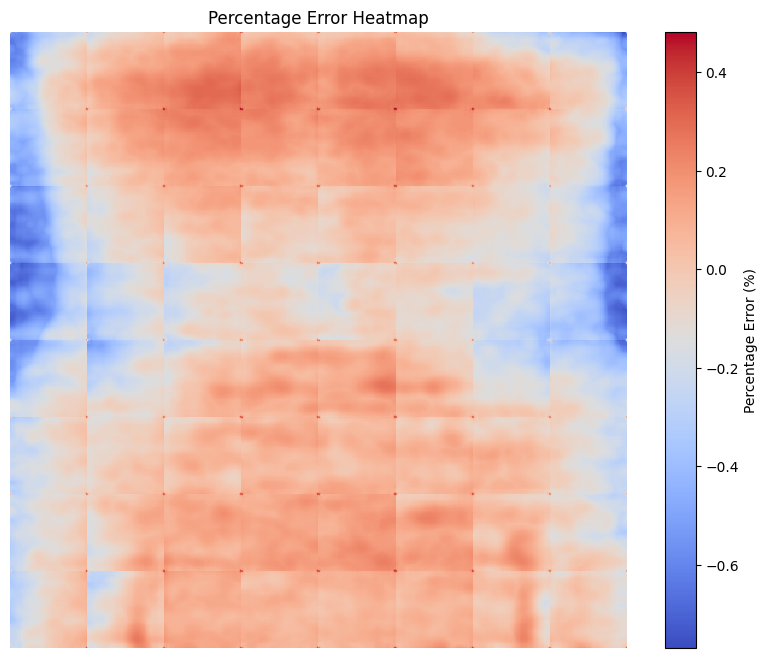

In [38]:
import numpy as np
import matplotlib.pyplot as plt

epsilon = 1e-8
ground_truth_final_safe = ground_truth_final + (ground_truth_final == 0) * epsilon

# Calculate the percentage error
percent_error = (ground_truth_final - average_prediction) / ground_truth_final_safe
average_percent_error = np.mean(np.abs(percent_error)) * 100  # Convert to percentage

print(f"Average Percentage Error: {average_percent_error:.2f}%")

# Plotting the percentage error as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(np.rot90(percent_error), cmap='coolwarm', interpolation='none')
plt.colorbar(label='Percentage Error (%)')
plt.title('Percentage Error Heatmap')
plt.axis('off')  # Hide the axes
plt.show()


In [71]:
model.load_state_dict(torch.load('./results/RatUNet_seed4_wdr.pth'))

<All keys matched successfully>

In [73]:
print(model)

RatUNet(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.0, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout(p=0.0, inplace=False)
    )
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchN